---
# ***SETTINGS***
---

In [1]:
# SARA: montiamo a drive per collegarci alla cartella desiderata
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# SARA: ecco la cartella desiderata
%cd /content/gdrive/MyDrive/ProgettoManoRobotica-AEA

/content/gdrive/MyDrive/ProgettoManoRobotica-AEA


In [84]:
# SARA: import delle librerie utili
import numpy as np # <-- libreria per calcoli base
import seaborn as sns
import matplotlib.pyplot as plt # <-- libreria per plottare le cose
import json # <-- libreria per formato dei file .json
from scipy import stats # <-- libreria per studi di correlazione
from scipy.interpolate import interp1d, RBFInterpolator, Rbf, interpn, RegularGridInterpolator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

In [9]:
# SARA: directory dei dati
filePath = '/content/gdrive/MyDrive/ProgettoManoRobotica-AEA/DB_Macchinine'
# show old debugging content (SARA: BOH)
showPrints = 1

# Variabile contenente tutte le letture (si spera)
readings = {
'AF3': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'AF4': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'T7':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'T8':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'Pz':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
}
}
METreadings = {
  'Engagement': [],
  'Excitement': [],
  'Stress': [],
  'Relaxation': [],
  'Interest': [],
  'Focus':[]
}

# variabili per contenere le fasi, sia i nomi che gli indici in cui iniziano
phaseNames = []
phaseIndex = [0]
METphaseNames = []
METphaseIndex = []

# Files da cui leggere i dati (SARA: Range scelto da NOI! Valore da MODIFICARE)
fileNames = range(21,22) # = file 21

# SARA: chi sono questi?
# indexes of usedfiles
#            0,1,2,3,4,7,8,9,0,1,3,4,5,6,7,9,1
initArray = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
endArray =  [7,4,5,5,5,5,5,5,6,5,5,6,7,8,5,5,5]
#            0,1,2,3,4,7,8,9,0,1,3,4,5,6,7,9,1
#     file 0: prova con musica, i dati potrebbero essere brutti
#     file 1: in pow c'è una fase in più, vediamo se funziona
#     file 9: aggiunto "nulla" dopo il sudokuù
#     file 14: prima fase macchinine rotta
#     file 15: ci sono cose strane post sudoku (path error)
#     file 16: ci si può fermare anche all'indice 6
badFiles = [5,6,12,18,20]
#file 5: inutilizzato, troppe fasi diverse, da rivedere
#file 6: rotto anche lui
#file 12, si è rotto qualcosa nelle fasi dell'esperimento (path_error)
#file 18, manca una fase in MET
#file 20, macchinine 2 rotte, fasi in più


# Canali e onde prescelte (SARA: in che senso prescelte? non sono quelle già presenti?)
selectedChannels = ('AF3','AF4','T7','T8','Pz')
selectedWaves = ('Theta', 'Alpha', 'BetaL', 'BetaH', 'BetaMean', 'Gamma')

---
# ***FUNCTIONS***
---

In [10]:
# SARA:
def met_adapt(indexStart, indexStop, METindexStart, METindexStop):
  # take one of the readings (doesn't matter which one) to calculate the length of the selected section
  # SARA: in questo caso calcola la lunghezza di tutte le readings, che è 7990
  x = range(len(readings['AF3']['Theta'][phaseIndex[indexStart]:phaseIndex[indexStop]+1]))
  # take the corresponding. SARA: il corrispondente è 98
  xMet = range(len(METreadings['Focus'][METphaseIndex[METindexStart]:METphaseIndex[METindexStop]+1]))
  # SARA: yFOC è l'insieme di tutti i valori di FOCUS che vanno dalla registrazione 0 alla 98
  yFOC = np.array(METreadings['Focus'][METphaseIndex[METindexStart]:METphaseIndex[METindexStop]+1])

  ### DA QUI IN POI NON CI PIACE ! ! !
  # SARA: rapp corrisponde a quante registrazioni POW si traducono in un valore MET
  rapp = len(x)//len(xMet) # lunghezza ideale di ogni tratto --> in questo caso 79
  yFOC_Fin = []
  # SARA: per ogni elemento di yFOC (tecnicamente sono 98)
  for id in yFOC:
    # SARA: per ogni elemento nel range di rapp (quindi 79)
    for i in range(rapp):
      # yFOC raccoglie 79 volte ciascun valore di FOCUS.
      # PERCHE'? Per colmare il gap tra x e xMet e avere quindi lo stesso numero di elementi
      yFOC_Fin.append(id)

  # SARA: pur di arrivare ad avere n. di elementi di yFOC pari a n. di elementi di x
  #       si aggiungono tanti elementi tutti uguali all'ultimo di yFOC finché non si arriva alla fine
  #       ... Non capisco se questa cosa si può considerare concettualmente accettabile (?)
  while(len(yFOC_Fin) < len(x)):
    yFOC_Fin.append(yFOC[len(yFOC)-1])

  ### DA QUI TORNA A STARMI BENE
  # SARA: kind of normalizzazione
  yFOC_Fin = yFOC_Fin/max(yFOC_Fin)

  plt.figure(1)
  # SARA: plot che mostra l'andamento normalizzato dei valori di focus lungo il numero delle normalizzazioni
  plt.plot(x,yFOC_Fin)
  return rapp, yFOC_Fin

def pow_adapt(rapp, yIn):
  yOut = []
  indexInit = 0
  m = 0
  for i in range(int(np.floor(len(yIn)/rapp))):
    m = np.mean(yIn[indexInit:indexInit+rapp-1])
    indexInit += rapp
    yOut = np.append(yOut, [m] * rapp) #[m] lo uso per avere la cella [m] inserita rapp volte
  if len(yIn)-indexInit > 0:
    yOut = np.append(yOut, [m] *  (len(yIn)-indexInit))
  return yOut


In [11]:
def avg(lst):
    return sum(lst) / len(lst)

def reduceData(lst, cut):
  outData = []
  for point in lst:
    if point > cut:
      outData.append(cut)
    else:
      outData.append(point)
  return outData

def printData(y, channel, wave, newFig = True, yFOC_Fin = [], ydiv = [], start = phaseIndex[0], end = phaseIndex[len(phaseIndex) - 1], division = False, channelD ='AF3', waveD = 'Alpha', reduced = False, withMean = False, rapp = 1, ww = 20, hh = 5):
      y = y[start:end+1]

      x = np.asarray(range(len(y)))/160
      print(start)
      print(end)
      print(len(y))
      print(len(yFOC_Fin))
      print(len(ydiv))
      lbl = wave + ' ' + channel
      if division:
        y = y/np.array(ydiv)
        lbl += (' / '+ waveD +' '+ channelD)
      if withMean:
        y = pow_adapt(rapp, y)
      if(reduced):
        y = reduceData(y, max(y)/8)
        lbl += 'reduced'

      #Calculate correlation
      # r = np.corrcoef(x,y)
      # if np.abs(r[0,1]) > 0.65:
      #  calculate spearmannn
      res = stats.spearmanr(yFOC_Fin,y)
      # if np.abs(r[0,1]) > 0.65:
      # res.statistics
      # if(res.statistic > 0.001):
      lbl += ('; Spearman: ' + str(np.round(res.statistic,4)) + '; pvalue = ' + str(np.round(res.pvalue)))

      # lbl += (' Corr: ' + str(r[0,1]))
      if newFig:
        plt.figure(figsize = (ww,hh))
        plt.title('Comparison between focus measurements and wave ratios')
        scale = max(y)/5
        q = max(y)/4
        plt.xlabel('time(s)')
        plt.ylabel('band power(μV²)')
        plt.plot(x,(yFOC_Fin*scale)+q, label = 'Focus')
      plt.plot(x,y, label = lbl)
      plt.legend(loc = 'best')
      # for xc in phaseIndex:
      #     plt.axvline(x=xc)

def justCovariance(y, channel, wave, yFOC_Fin = [], ydiv = [], start = phaseIndex[0], end = phaseIndex[len(phaseIndex) - 1], division = False, channelD ='AF3', waveD = 'Alpha', reduced = False, withMean = False, rapp = 1, ww = 20, hh = 5):
      y = y[start:end+1]
      if division:
        y = y/np.array(ydiv)
      if withMean:
        y = pow_adapt(rapp, y)
      if(reduced):
        y = reduceData(y, max(y)/8)
      #Calculate correlation
      r = np.corrcoef(yFOC_Fin,y)
      # if np.abs(r[0,1]) > 0.65:
      return(r[0,1])

def justSpearman(y, channel, wave, yFOC_Fin = [], ydiv = [], start = phaseIndex[0], end = phaseIndex[len(phaseIndex) - 1], division = False, channelD ='AF3', waveD = 'Alpha', reduced = False, withMean = False, rapp = 1, ww = 20, hh = 5):
      y = y[start:end+1]
      print(start)
      print(end)
      print(len(y))
      yFOC_Fin = yFOC_Fin[start:end+1]
      ydiv = ydiv[start:end+1]
      if division:
        y = y/np.array(ydiv)
      if withMean:
        y = pow_adapt(rapp, y)
      if(reduced):
        y = reduceData(y, max(y)/8)
      print(len(y))

      #Calculate correlation
      # print(len(yFOC_Fin))
      # print(len(y))
      res = stats.spearmanr(yFOC_Fin,y)
      # if np.abs(r[0,1]) > 0.65:
      return(res.statistics)

---
# ***1. DAVIDE'S METHOD: READING DATA & READAPTING MISMATCH BETWEEN POW AND MET***
---

In [12]:
############################
######## READ DATA #########
############################
phaseIndex = []

# SARA: i = 21 e basta
for i in fileNames:
  i0 = "{0:0>3}".format(i)
  phaseNames = []
  phaseIndex = []
  timeNames = []
  METphaseNames = []
  METphaseIndex = []
  METtimeNames = []

  ### POW ###
  currFile = 'POW{0:0>3}.json'.format(i)
  f = open(filePath + '/' + currFile)
  dataPOW = json.load(f)
  currPhase = ''
  currTime = ''
  for index, item in enumerate(dataPOW[i0]['Readings'].values()):
    if(item['Phase'])!=currPhase:
      phaseIndex.append(index)
      # SARA: bella sta funzione item, chissà quanto ho cercato una roba simile
      #       mi tornerà utile in futuro
      currPhase = item['Phase']
      phaseNames.append(item['Phase'])

    # SARA: questo if l'ho aggiunto io per creare una lista contenente tutti i tempi
    if (item['Time'])!= currTime:
      timeNames.append(item['Time'])
      currTime = item['Time']

    for c in selectedChannels:
      for w in selectedWaves:
        # SARA: BetaMean nasce perché si fa la media tra le 2 beta, ci sta !
        #       Questo, ad esempio, io non lo avevo fatto: avevo preso solo BetaL
        #       Ora non ricordo come mai, ma c'era sicuramente una ragione
        #       comprovata da della ricerca bibliografica pregressa
        #       Ciò comunque non toglie che, escludere a priori BetaH, fosse
        #       un azzardo che non posso dire di permettermi
        if w == 'BetaMean':
          readings[c][w].append((float(item[c]['BetaH'])+float(item[c]['BetaL']))/2)
        else:
          readings[c][w].append(float(item[c][w]))
  phaseIndex.append(index)
  if(showPrints):
    print("POW File n° " + str(i))
    print("POWphaseNames:", phaseNames)
# SARA: phaseIndex dice a partire da quale recording si inizia una nuova fase;
#       di conseguenza ottengo anche il numero di recordings per fase
    print("--> with relative phase index:", phaseIndex)
# SARA: insomma, alla fine della fiera, tutto sto giro serve per salvare il nome delle
#       fasi di un file POW

    print(timeNames)
    print(len(timeNames))


  ### MET ###
  currFile = 'MET{0:0>3}.json'.format(i)
  f = open(filePath + '/' + currFile)
  dataMET = json.load(f)
  currPhase = ''
  currTime = ''
  for index,item in enumerate(dataMET[i0]['Readings'].values()):
    if(item['Phase'])!=currPhase:
      METphaseNames.append(item['Phase'])
      METphaseIndex.append(index)
      currPhase = item['Phase']
    METreadings['Focus'].append(float(item['Focus']))

    # SARA: questo if l'ho aggiunto io per creare una lista contenente tutti i tempi
    if (item['Time'])!= currTime:
      METtimeNames.append(item['Time'])
      currTime = item['Time']

  METphaseIndex.append(index)
  if(showPrints):
    print("\nMET File n° " + str(i))
    print("METphaseNames:", METphaseNames)
    print("--> with relative phase index:", METphaseIndex)
    print("\nMET phase count = ", len(METphaseNames), "; POW phase count = ", len(phaseNames))
    print(METtimeNames)
    print(len(METtimeNames))

# TO SUM UP: abbiamo 5 fasi sia per POW che per MET, MA il numero di elementi per fase è DIVERSO
# --> c'è un MISMATCH

POW File n° 21
POWphaseNames: ['baseline 021', 'baseline occhi chiusi', 'Macchinine 1', 'sudoku', 'macchinine 2']
--> with relative phase index: [0, 1514, 3290, 4774, 6194, 7789]
['19:24:31', '19:24:32', '19:24:33', '19:24:34', '19:24:35', '19:24:36', '19:24:37', '19:24:38', '19:24:39', '19:24:40', '19:24:41', '19:24:42', '19:24:43', '19:24:44', '19:24:45', '19:24:46', '19:24:47', '19:24:48', '19:24:49', '19:24:50', '19:24:51', '19:24:52', '19:24:53', '19:24:54', '19:24:55', '19:24:56', '19:24:57', '19:24:58', '19:24:59', '19:25:00', '19:25:01', '19:25:02', '19:25:03', '19:25:04', '19:25:05', '19:25:06', '19:25:07', '19:25:08', '19:25:09', '19:25:10', '19:25:11', '19:25:12', '19:25:13', '19:25:14', '19:25:15', '19:25:16', '19:25:17', '19:25:18', '19:25:19', '19:25:20', '19:25:21', '19:25:22', '19:25:23', '19:25:24', '19:25:25', '19:25:26', '19:25:27', '19:25:28', '19:25:29', '19:25:30', '19:25:31', '19:25:32', '19:25:33', '19:25:34', '19:25:35', '19:25:36', '19:25:37', '19:25:38', '19:

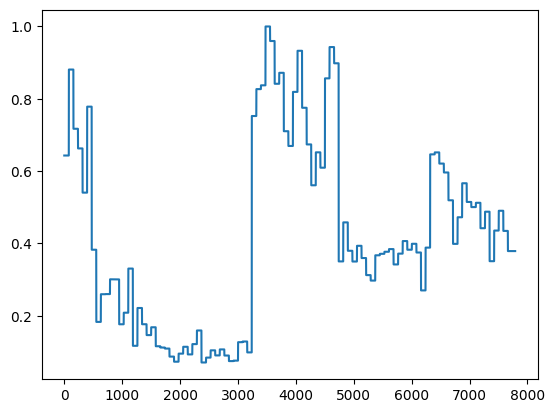

In [13]:
# SARA: funzione per colmare il MISMATCH
# --> questa è la funzione vecchia, che non ci piace e non ci piace perché preggia la lunghezza di MET a quella di POW in maniera impropria.
# nel senso che calcola il rapporto tra il numero di readingsPOW e readingsMET e "allunga" ogni valore di MET per quel valore di rapporto.
# ciò non ci piace perché questo metodo non permette di mantenere l'accoppiamento temporale tra MET e POW
# e di sicuro non tiene più conto delle fasi.

# per il momento, però, è tutto ciò che abbiamo.

#prepare outData
rapp, yFOC_Fin = met_adapt(0,5,0,5)

---
# ***1. CORRELATION ANALYSYS***
---

Text(0, 0.5, 'range [0-1]')

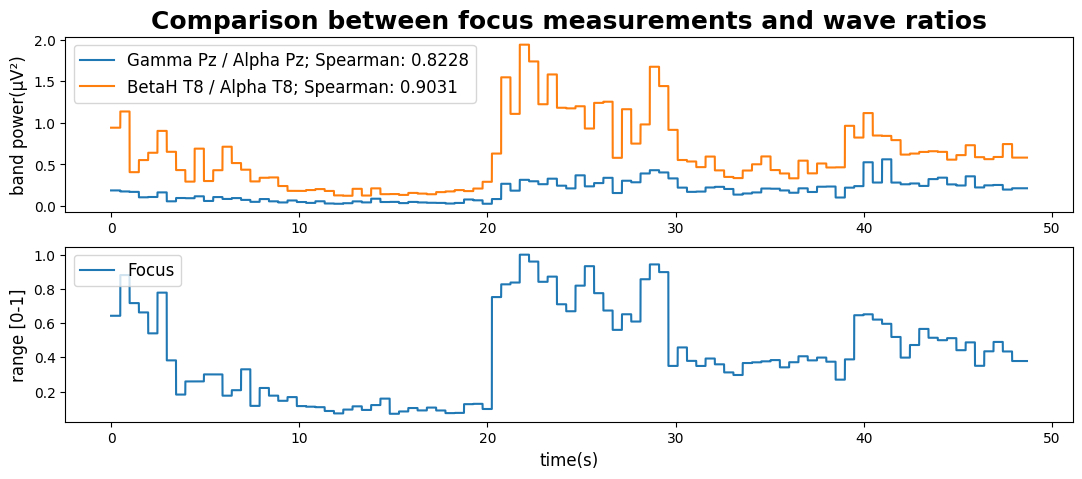

In [14]:
# SARA: questa è la prova che esistono dei valori di rapporti che hanno rivelato correlazione con il parametro FOCUS.
#       è un dato utile, anche se noi ora vogliamo rivolgerci verso l'interpolazione
#
# l'unico difetto è che, a mio avviso, questo grafico è poco intuitivo, perché sopra è come se confrontasse i due diversi rapporti e
# focus è sotto, ma il vero rapporto significativo è quello tra singolo rapporto e focus, perciò sistemo sto grafico nel prossimo blocco.

fig, ax = plt.subplots(2,1,figsize=(13,5))
# fig.suptitle('Comparison between focus measurements and wave ratios', fontsize = 14, fontweight = 'bold', verticalalignment = 'bottom')
# ELETTRODO Pz
c = 'Pz'
# ONDE Gamma e Alpha
w = 'Gamma'
ww = 'Alpha'

# SARA: Calcolo del rapporto dei valori di onde gamma/alpha
y = readings[c][w]/np.asarray(readings[c][ww])
#x = np.asarray(range(len(y)))
# SARA: che cazzo vuol significare 160?
x = np.asarray(range(len(y)))/160

y = pow_adapt(rapp, y)
res = stats.spearmanr(yFOC_Fin, y)
lbl = w+' '+c+' / '+ ww +' '+ c + '; Spearman: ' + str(np.round(res.statistic,4))
ax[0].plot(x,y, label = lbl)
ax[0].legend(loc = 'best')
ax[0].set_title('Comparison between focus measurements and wave ratios', fontsize = 18, fontweight = 'bold')
# ax[0].title.set_text('Comparison between focus measurements and wave ratios')

c = 'T8'
w = 'BetaH'
y = readings[c][w]/np.asarray(readings[c][ww])
y = pow_adapt(rapp, y)
res = stats.spearmanr(yFOC_Fin,y)
lbl = w+' '+c+' / '+ ww +' '+ c + '; Spearman: ' + str(np.round(res.statistic,4))
ax[0].plot(x,y, label = lbl)
ax[0].legend(loc = 'best')

ax[0].set_ylabel('band power(μV²)', fontsize = 12)
ax[0].legend(fontsize = 12, loc = 'best')

ax[1].plot(x,(yFOC_Fin), label = 'Focus')
ax[1].legend(fontsize = 12, loc = 'upper left')
ax[1].set_xlabel('time(s)', fontsize = 12,)
ax[1].set_ylabel('range [0-1]', fontsize = 12)
      # for xc in phaseIndex:
      #     plt.axvline(x=xc)

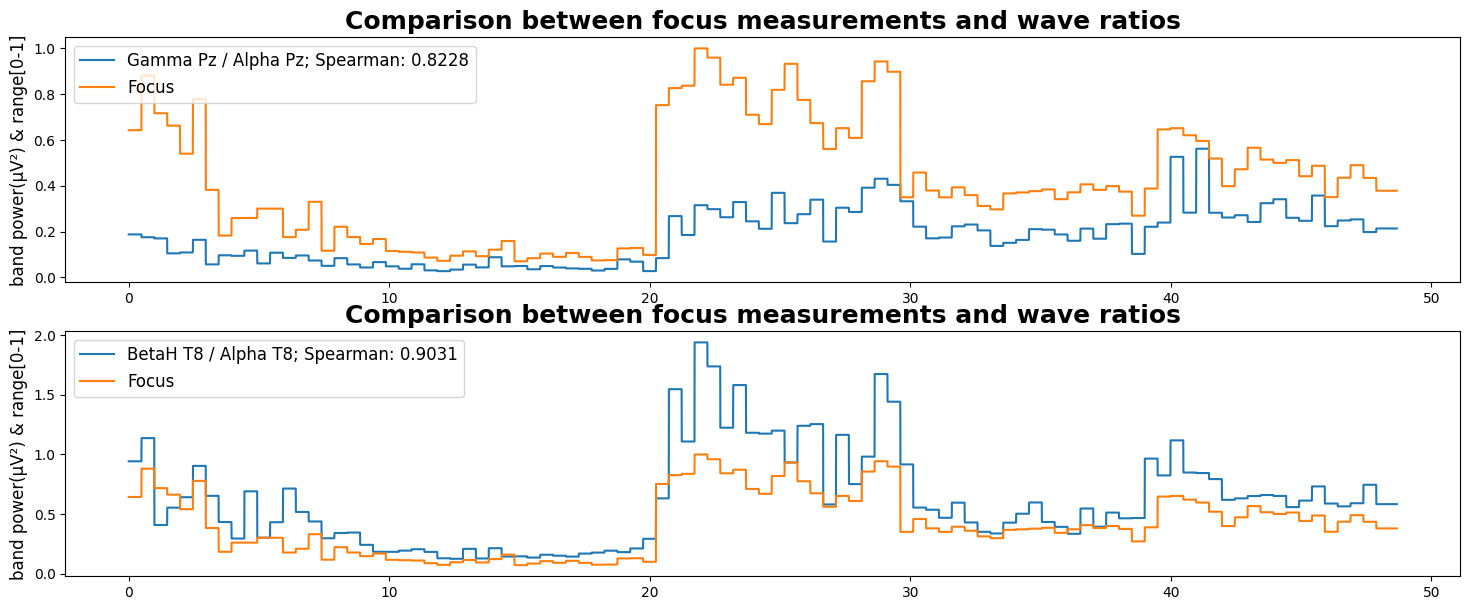

In [15]:
# SARA: è lo stesso blocco di prima ma che, spero, si capisce meglio. Sostanzialmente, in ciascun grafico, metto a confronto
#       le entità che sono veramente a confronto, vale a dire il rapporto con i valori di focus.

fig, ax = plt.subplots(2,1,figsize=(18,7))
# fig.suptitle('Comparison between focus measurements and wave ratios', fontsize = 14, fontweight = 'bold', verticalalignment = 'bottom')
# ELETTRODO Pz
c = 'Pz'
# ONDE Gamma e Alpha
w = 'Gamma'
ww = 'Alpha'

# SARA: Calcolo del rapporto dei valori di onde gamma/alpha
y = readings[c][w]/np.asarray(readings[c][ww])
#x = np.asarray(range(len(y)))
# SARA: che cazzo vuol significare 160?
x = np.asarray(range(len(y)))/160

y = pow_adapt(rapp, y)
res = stats.spearmanr(yFOC_Fin,y)
lbl = w+' '+c+' / '+ ww +' '+ c + '; Spearman: ' + str(np.round(res.statistic,4))
ax[0].plot(x,y, label = lbl)
ax[0].legend(fontsize = 12, loc = 'best')
ax[0].set_title('Comparison between focus measurements and wave ratios', fontsize = 18, fontweight = 'bold')
# ax[0].title.set_text('Comparison between focus measurements and wave ratios')
ax[0].plot(x,(yFOC_Fin), label = 'Focus')
ax[0].legend(fontsize = 12, loc = 'upper left')
ax[0].set_ylabel('band power(μV²) & range[0-1]', fontsize = 12)

c = 'T8'
w = 'BetaH'
y = readings[c][w]/np.asarray(readings[c][ww])
y = pow_adapt(rapp, y)
res = stats.spearmanr(yFOC_Fin,y)
lbl = w+' '+c+' / '+ ww +' '+ c + '; Spearman: ' + str(np.round(res.statistic,4))
ax[1].plot(x,y, label = lbl)
ax[1].legend(loc = 'best')
ax[1].set_title('Comparison between focus measurements and wave ratios', fontsize = 18, fontweight = 'bold')
ax[1].set_ylabel('band power(μV²) & range[0-1]', fontsize = 12)
ax[1].plot(x,(yFOC_Fin), label = 'Focus')
ax[1].legend(fontsize = 12, loc = 'upper left')
#ax[1].set_xlabel('time(s)', fontsize = 12,)
#ax[1].set_ylabel('range [0-1]', fontsize = 12)
      # for xc in phaseIndex:
      #     plt.axvline(x=xc)


---
# ***1st ATTEMPT: INTERPOLATION w.r.t. TIME***
---

In [16]:
# SARA: tentativo a caso con inter1p, non so manco io cosa stavo facendo
interp_func = interp1d(x, yFOC_Fin, kind = 'linear')

The coefficients of the resulting function are: [ 0.00000000e+000  0.00000000e+000 -0.00000000e+000 -0.00000000e+000
  0.00000000e+000 -0.00000000e+000 -0.00000000e+000 -0.00000000e+000
 -0.00000000e+000 -0.00000000e+000 -2.13040789e-143  8.99815877e-142
  4.99151030e-140  1.03588755e-138 -2.70927655e-137 -3.85366957e-135
 -2.25711995e-133 -9.15534057e-132 -2.39611271e-130  4.77537177e-130
  5.61804986e-127  4.55842352e-125  2.58059957e-123  1.16874777e-121
  4.18412117e-120  9.57098946e-119 -1.22879875e-117 -3.25827590e-115
 -2.56956903e-113 -1.50728629e-111 -7.35210822e-110 -3.00900198e-108
 -9.59763360e-107 -1.52160782e-105  8.84804412e-104  1.14441720e-101
  8.14335542e-100  4.59218007e-098  2.19366016e-096  8.82536136e-095
  2.73179311e-093  3.63510161e-092 -3.20285572e-090 -3.73134297e-088
 -2.58422093e-086 -1.42911883e-084 -6.65363654e-083 -2.55285892e-081
 -6.97312969e-080 -1.39697554e-079  1.54031767e-076  1.40592751e-074
  8.82299615e-073  4.46902884e-071  1.84637848e-069  5.

/usr/local/lib/python3.10/dist-packages/numpy/lib/polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


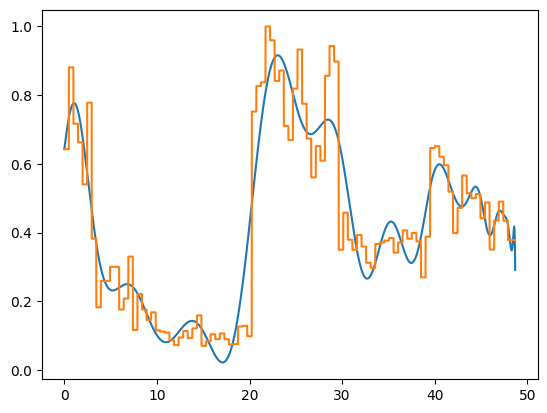

In [17]:
# SARA: per provare, iniziamo a lavorare con x, che sarebbe il tempo
#       LO SO che noi non vogliamo interpolare FOCUS secondo il tempo, ma ogni cosa a suo tempo
x = np.asarray(range(len(y)))/160
# fit a polynomial to the data
coeffs = np.polyfit(x, yFOC_Fin, deg=100) # posso scegliere l'ordine che voglio, chiaramente > è meglio è

# create a function from the coefficients
f = np.poly1d(coeffs)

# print the coefficients
print(f"The coefficients of the resulting function are: {coeffs}")

xlist = x.tolist()
fnew = np.polyval(coeffs, xlist)
fnewlist = fnew.tolist()
plt.plot(xlist, fnewlist)
plt.plot(xlist, yFOC_Fin)

# SARA: ok, ora ho capito come funziona sta roba, anche se io non voglio interpolare rispetto al tempo
# ora passiamo allo step successivo: voglio una x multidimensionale

---
#***2nd ATTEMPT: INTERPOLATION w.r.t. FOCUS***
---

In [18]:
# SARA: voglio creare la mia mega x multidimensionale
# in sostanza è una lista di 5 * 5 e in ciascuno di questi elementi ci sono in realtà 7790 elementi
selectedChannels = ('AF3','AF4','T7','T8','Pz')
selectedWaves = ('Theta', 'Alpha', 'BetaL', 'BetaH', 'Gamma')

# SARA: lista che conterrà i miei amati valori
lst = []

# SARA: per ogni canale...
for c in selectedChannels:
  # SARA: ...creo una riga
  row = []
  # SARA: per ogni onda
  for w in selectedWaves:
    # SARA: in quella riga, per ogni colonna, metto un valore di onda
    row.append(readings[c][w])
  # SARA: dopo aver aggiunto tutti i valori di onda per canale (= riga), aggiungo la riga alla lista di mio interesse
  lst.append(row)

  # SARA: conversione della lista in un array
lst = np.asarray(lst)

In [19]:
# SARA: alcuni check sul formato e dimensioni per verificare che, al momento, ho 5 righe * 5 colonne, ciascuna contenente 7790 valori
#       ai fini del mio processo di interpolazione, però, io ho bisogno di una matrice 25 * 7790
print("Valori di una specifica onda ('0' == Theta) in uno specifico canale ('0' == AF3) per tutte le registrazioni:", lst[0][0])
print("\nShape della mia lista:", lst.shape)

Valori di una specifica onda ('0' == Theta) in uno specifico canale ('0' == AF3) per tutte le registrazioni: [ 0.922  0.947  0.899 ...  4.747 10.654 20.007]

Shape della mia lista: (5, 5, 7790)


In [20]:
# SARA: RESHAPE --> eseguo un reshape e mi assicuro che tutto torni
lst25_len = np.reshape(lst, (25, len(lst[0][0])))
print("Nuova shape della mia lista:", lst25_len.shape)

Nuova shape della mia lista: (25, 7790)


In [21]:
# SARA: ho verificato che la mia funzione di interpolazione vuole la stessa lunghezza tra la matrice dei valori delle onde e i valori di Focus
#       e si da il caso che questi valori siano 7790, quindi TRANSPOSITION:
xdata = np.transpose(lst25_len)
print("Nuova shape della mia lista transposta:", xdata.shape)

Nuova shape della mia lista transposta: (7790, 25)


In [22]:
# SARA: funzione di interpolazione che permette di lavorare con in input matridi bidimensionali
rbf = RBFInterpolator(xdata, yFOC_Fin, epsilon=2)

In [23]:
# SARA: una volta ottenuta la mia funzione, la ri-applico sui dati di partenza per ottenere la funziona risultante che, in teora,
# dovrebbe tracciare proprio il comportamento di focus
ynew = rbf(xdata)

(0.0, 100.0)

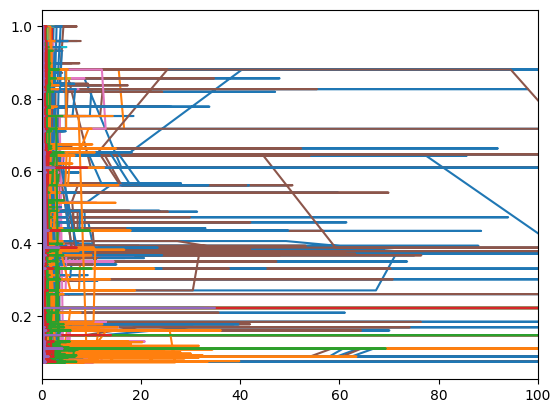

In [24]:
# SARA: plotto y-x: l'andamento della funzione che definisce il comportamento di focus in funzione dei dati EEG
plt.plot(xdata, ynew)
plt.xlim(0,100)

# ok, non sembra avere molto senso, ma chissene, a noi interessa che questa funzione funzioni, quindi proviamo ad applicarla

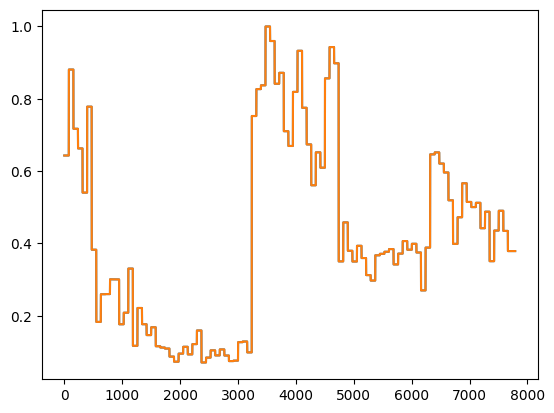

In [25]:
# confronto tra y ottenuta dalla funzione e y attesa
plt.figure()
plt.plot(ynew)
plt.plot(yFOC_Fin)

---
# ***--> 2nd ATTEMPT APPLIED TO A DIFFERENT DATASET***
---

In [26]:
# SARA: da scegliere! Nuovo file preso in esame
fileNames_2 = range(2,3) # questo è il 2

readings = {
'AF3': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'AF4': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'T7':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'T8':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'Pz':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
}
}
METreadings = {
  'Engagement': [],
  'Excitement': [],
  'Stress': [],
  'Relaxation': [],
  'Interest': [],
  'Focus':[]
}

############################
######## READ DATA #########
############################
phaseIndex = []

# SARA: i = 21 e basta
for i in fileNames_2:
  i0 = "{0:0>3}".format(i)
  phaseNames = []
  phaseIndex = []
  timeNames = []
  METphaseNames = []
  METphaseIndex = []
  METtimeNames = []

  ### POW ###
  currFile = 'POW{0:0>3}.json'.format(i)
  f = open(filePath + '/' + currFile)
  dataPOW = json.load(f)
  currPhase = ''
  currTime = ''
  for index, item in enumerate(dataPOW[i0]['Readings'].values()):
    if(item['Phase'])!=currPhase:
      phaseIndex.append(index)
      # SARA: bella sta funzione item, chissà quanto ho cercato una roba simile
      #       mi tornerà utile in futuro
      currPhase = item['Phase']
      phaseNames.append(item['Phase'])

    # SARA: questo if l'ho aggiunto io per creare una lista contenente tutti i tempi
    if (item['Time'])!= currTime:
      timeNames.append(item['Time'])
      currTime = item['Time']

    for c in selectedChannels:
      for w in selectedWaves:
        # SARA: BetaMean nasce perché si fa la media tra le 2 beta, ci sta !
        #       Questo, ad esempio, io non lo avevo fatto: avevo preso solo BetaL
        #       Ora non ricordo come mai, ma c'era sicuramente una ragione
        #       comprovata da della ricerca bibliografica pregressa
        #       Ciò comunque non toglie che, escludere a priori BetaH, fosse
        #       un azzardo che non posso dire di permettermi
        if w == 'BetaMean':
          readings[c][w].append((float(item[c]['BetaH'])+float(item[c]['BetaL']))/2)
        else:
          readings[c][w].append(float(item[c][w]))
  phaseIndex.append(index)
  if(showPrints):
    print("POW File n° " + str(i))
    print("POWphaseNames:", phaseNames)
# SARA: phaseIndex dice a partire da quale recording si inizia una nuova fase;
#       di conseguenza ottengo anche il numero di recordings per fase
    print("--> with relative phase index:", phaseIndex)
# SARA: insomma, alla fine della fiera, tutto sto giro serve per salvare il nome delle
#       fasi di un file POW

    #print(timeNames)
    #print(len(timeNames))


  ### MET ###
  currFile = 'MET{0:0>3}.json'.format(i)
  f = open(filePath + '/' + currFile)
  dataMET = json.load(f)
  currPhase = ''
  currTime = ''
  for index,item in enumerate(dataMET[i0]['Readings'].values()):
    if(item['Phase'])!=currPhase:
      METphaseNames.append(item['Phase'])
      METphaseIndex.append(index)
      currPhase = item['Phase']
    METreadings['Focus'].append(float(item['Focus']))

    # SARA: questo if l'ho aggiunto io per creare una lista contenente tutti i tempi
    if (item['Time'])!= currTime:
      METtimeNames.append(item['Time'])
      currTime = item['Time']

  METphaseIndex.append(index)
  if(showPrints):
    print("\nMET File n° " + str(i))
    print("METphaseNames:", METphaseNames)
    print("--> with relative phase index:", METphaseIndex)
    print("\nMET phase count = ", len(METphaseNames), "; POW phase count = ", len(phaseNames))
    #print(METtimeNames)
    #print(len(METtimeNames))

# TO SUM UP: abbiamo 5 fasi sia per POW che per MET, MA il numero di elementi per fase è DIVERSO
# --> c'è un MISMATCH

POW File n° 2
POWphaseNames: ['Baseline 002', 'Baseline occhi chiusi', 'Macchinine 1', 'sudoku', 'macchinine 2']
--> with relative phase index: [0, 1433, 2855, 4351, 6303, 7762]

MET File n° 2
METphaseNames: ['Baseline 002 F25', 'Baseline occhi chiusi', 'Macchinine 1', 'sudoku', 'macchinine 2']
--> with relative phase index: [0, 18, 35, 54, 78, 96]

MET phase count =  5 ; POW phase count =  5


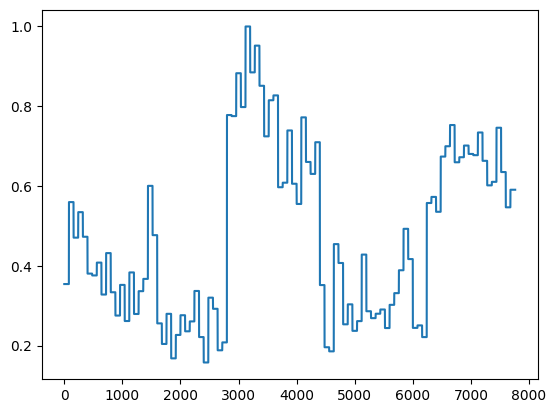

In [27]:
rapp, yFOC_Fin2 = met_adapt(0,5,0,5)

In [28]:
# SARA: voglio creare la mia mega x multidimensionale
# in sostanza è una lista di 5 * 5 e in ciascuno di questi elementi ci sono in realtà 7790 elementi
selectedChannels = ('AF3','AF4','T7','T8','Pz')
selectedWaves = ('Theta', 'Alpha', 'BetaL', 'BetaH', 'Gamma')

# SARA: lista che conterrà i miei amati valori
lst = []

# SARA: per ogni canale...
for c in selectedChannels:
  # SARA: ...creo una riga
  row = []
  # SARA: per ogni onda
  for w in selectedWaves:
    # SARA: in quella riga, per ogni colonna, metto un valore di onda
    row.append(readings[c][w])
  # SARA: dopo aver aggiunto tutti i valori di onda per canale (= riga), aggiungo la riga alla lista di mio interesse
  lst.append(row)

  # SARA: conversione della lista in un array
lst = np.asarray(lst)

In [29]:
# SARA: reshape e transpose per arrivare a 25 * #campioni
lst25_len = np.reshape(lst, (25, len(lst[0][0])))
xdata2 = np.transpose(lst25_len)

In [30]:
# SARA: applicazione della funzione
ynew2 = rbf(xdata2)

(0.0, 2.0)

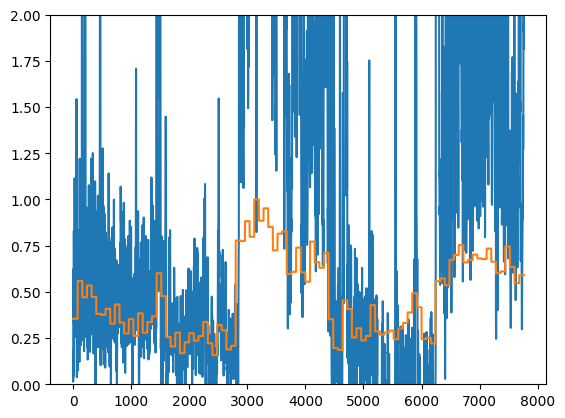

In [31]:
# SARA: confronto tra output funzione interpolazione e output atteso per verificare la performance della funzione
plt.figure()
plt.plot(ynew2)
plt.plot(yFOC_Fin2)
plt.ylim(0,2)

---
# ***2. AVERAGE METHOD: CORRECT READAPTING MISMATCH BETWEEN POW AND MET***
---

Faccio prima un resoconto di ciò che mi piacerebbe riuscire a fare:

Io so che, prendendo un file a caso (come 21), ho un file POW e un file MET che hanno "lunghezze diverse". Nel senso che il numero di readings di POW è maggiore
del numero di valori di Focus contenuti in MET. Perché? Perché, per via di motivi legati alla capacità risolutiva del caschetto, io ho più readings per stesso TimeStep. Al contrario, ho solo un valore di Focus per TimeStep.
Questo ci porta a pensare che il valore di Focus sia unico per tutte le registrazioni che hanno stesso TimeStep e quindi Focus è un valore ottenuto dalla mediazione di più readings.

Questo lo aveva capito anche Davide e l'approccio che ha scelto lui era di ripetere ogni valore di focus per quanto era il "mismatch" tra MET e POW. Ciò però, come già detto, porta a molte imprecisioni, per non dire incorrettezze.

Ciò che vorremmo noi è individuare tutte le readings con stesso TimeStep e, per ogni TimeStep, calcolare la media dei valori delle onde per ciascun canale. Alla fine, vogliamo avere un nuovo file POW che abbia un numero di readings quanto è il numero di TimeSteps e, quindi, pari al numero di valori di Focus totali.

Prima ancora di fare ciò è opportun assicurarsi che tutti i TimeSteps contenuti in POW siano anche contenuti in MET. SPOILER: non è così, quindi vanno pure tolti le recordings dei TimeSteps che non hanno corrispondente focus.

Potrebbe essere utile anche provare a suddividere il discorso in tipi di esperimenti diversi. Vero è che noi miriamo a studiare il comportamento dell'eeg in toto, ma magari, almeno all'inizio, potrebbe aiutare a facilitare la computazione.

In [32]:
print("Sto lavorando con il file 22; questo viene definito da 'fileNames' di valore", fileNames)
print("Il file POW021 contiene Readings a diversi istanti temporali.")
print("--> L'insieme di tutti e solo i diversi istanti temporali, presi una volta sola è:", len(timeNames))

Sto lavorando con il file 22; questo viene definito da 'fileNames' di valore range(21, 22)
Il file POW021 contiene Readings a diversi istanti temporali.
--> L'insieme di tutti e solo i diversi istanti temporali, presi una volta sola è: 976


In [33]:
# SARA: primo check! il numero dei timeSteps in comune tra MET e POW corrisponde a tutti i timeSteps di MET
#      ottimo! quindi posso usare questi come risultato e fare un confronto tra i tempi contenuti in POW, usando come riferimento MET
usefulTimes = []
for time in timeNames:
  if time in METtimeNames:
    usefulTimes.append(time)

print("n° dei TimeSteps che POW e MET hanno in comune:", len(usefulTimes))

n° dei TimeSteps che POW e MET hanno in comune: 97


In [34]:
# SARA: creo una lista contenente tutti i valori di tempo di POW
met_times = []
from datetime import datetime
for index, item in enumerate(dataMET[i0]['Readings'].values()):
  met_times.append(item['Time'])
print("Il file MET ha", len(met_times), "diversi istanti di tempo")
#print(met_times)
print("Il file POW ha", len(dataPOW[i0]['Readings']), "diversi istanti di tempo")

Il file MET ha 97 diversi istanti di tempo
Il file POW ha 7763 diversi istanti di tempo


In [35]:
# SARA: inizializzo il dictionary in cui voglio inserire tutti gli elementi di POW che hanno timeSteps uguali a quelli di MET
result_dict = {
        i0: {
            "Readings": {}
        }
}

In [36]:
# SARA: riempio questo dictionary con il criterio per cui, se la data Reading di
#       POW ha un timeStep tra quelli di MET allora va bene e lo inserisco
n = 0
for index, item in enumerate(dataPOW[i0]['Readings'].values()):
  if item['Time'] in met_times:
    key = f"{n:06d}"
    result_dict[i0]["Readings"][key] = item
    n = n+1

print("Il nuovo file POW ha", len(result_dict[i0]['Readings']), "istanti di tempo diversi, tutti in comune con il file MET")

Il nuovo file POW ha 773 istanti di tempo diversi, tutti in comune con il file MET


In [37]:
# SARA: qui creo un nuovo dictionary che, come chiavi, ha proprio i nomi degli istanti temporali. I dati li prende dal nuovo POW.
#       In pratica, per ogni nuovo istante temporale, salva dentro tutti i corrispettivi dati di POW.
#       Se invece un istante temporale si ripete, i valori del file POW per quell'elemento vengono mediati con i dati già presenti
#       DISCLAIMER: Non è una media aritmetica, ma è pur sempre un valore mediato e quindi più valido dei valori singoli

selectedChannels = ('AF3','AF4','T7','T8','Pz')
selectedWaves = ('Theta', 'Alpha', 'BetaL', 'BetaH', 'Gamma')

time_to_readings = {}
for index, item in enumerate(result_dict[i0]['Readings'].values()):
    time = str(item["Time"])
    if not time in time_to_readings:
      time_to_readings[time] = {}
      time_to_readings[time]['Phase'] = item['Phase']
      time_to_readings[time]['AF3'] = item['AF3']
      time_to_readings[time]['T7'] = item['T7']
      time_to_readings[time]['Pz'] = item['Pz']
      time_to_readings[time]['T8'] = item['T8']
      time_to_readings[time]['AF4'] = item['AF4']
    else:
      for c in selectedChannels:
        for w in selectedWaves:
          time_to_readings[time][c][w] = (float(item[c][w]) + float(time_to_readings[time][c][w]))/2

---
# ***2. INTERPOLATION WITH READAPTING MISMATCH PROBLEM SOLVED***
---

In [38]:
# SARA: Proviamo a ripetere tutta la procedura da capo per svolgere l'interpolazione
#       Innanzitutto, per rimanere il più fedele possibile al metodo di prima, devo creare "readings"
readings2 = {
'AF3': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'AF4': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'T7':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'T8':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
},
'Pz':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'BetaMean': [],
  'Gamma': [],
}
}

In [39]:
# SARA: in questo readings appena inizializzato, inserisco i valori per ogni canale e per ogni onda
for index, item in enumerate(time_to_readings.values()):
  for c in selectedChannels:
      for w in selectedWaves:
        readings2[c][w].append(item[c][w])

In [40]:
# SARA: reasings è un dict e io mi trovo più comoda con liste/array
#       Quindi creo una nuova lista lst con i canali per le righe e le onde per colonne
#       In ogni "elemento singolo" ci saranno tutti i valori di registrazione di quell'onda e quel canale

lst = []
i = 0
# SARA: per ogni canale...
for c in selectedChannels:
  print("---> Step: ", i)
  print("Canale:", c)
  # SARA: ...creo una riga
  row = []
  # SARA: per ogni onda
  for w in selectedWaves:
    print("Onda:", w)
    # SARA: in quella riga, per ogni colonna, metto un valore di onda
    row.append(readings2[c][w])
  # SARA: dopo aver aggiunto tutti i valori di onda per canale (= riga), aggiungo la riga alla lista di mio interesse
  lst.append(row)
  i = i+1

lst = np.asarray(lst)

print("la mia lista ha dimensione:", lst.shape)

---> Step:  0
Canale: AF3
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma
---> Step:  1
Canale: AF4
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma
---> Step:  2
Canale: T7
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma
---> Step:  3
Canale: T8
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma
---> Step:  4
Canale: Pz
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma
la mia lista ha dimensione: (5, 5, 97)


In [41]:
# SARA: io però voglio passare ad una matrice che abbia 25 colonne, cioè tutte le combinazioni di canali e onde
lst25_len = np.reshape(lst, (25, len(lst[0][0])))
print("Nuova shape della mia lista :", lst25_len.shape)

Nuova shape della mia lista : (25, 97)


In [42]:
# SARA: per via di vincoli della funzione di interpolazione, ho bisogno di avere la stessa "lunghezza" tra entità che voglio interpolare
xdata = np.transpose(lst25_len)
print("Nuova shape della mia lista transposta:", xdata.shape)

Nuova shape della mia lista transposta: (97, 25)


In [43]:
# SARA: setto anche il vettore dei valori di FOCUS
yFOC2 = np.array(METreadings['Focus'][METphaseIndex[0]:METphaseIndex[5]+1])
# reshape mi serve per passare da (98,) a (98,1)
yFOC_corr = yFOC2.reshape(-1, 1)
print("shape di yFOC:", yFOC2.shape)

shape di yFOC: (97,)


In [44]:
# SARA: funzione di interpolazione che permette di lavorare con in input matridi bidimensionali
rbf = RBFInterpolator(xdata, yFOC2, epsilon=2)

In [45]:
# SARA: ri-applichiamola su dati forniti
ynew = rbf(xdata)

(0.0, 100.0)

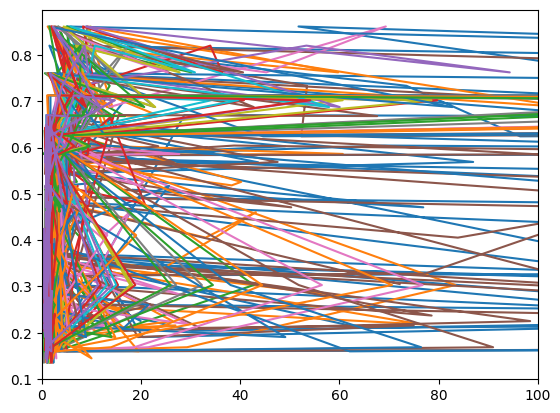

In [46]:
# risultato grafico della funzione di itrolazione di focus rispetto alle onde
plt.plot(xdata, ynew)
plt.xlim(0,100)

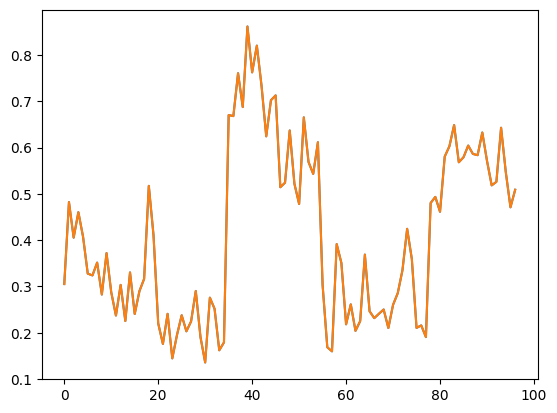

In [47]:
# confronto tra y ottenuta dalla funzione e y attesa
plt.figure()
plt.plot(ynew)
plt.plot(yFOC2)

---
# ***2. ALL POSSIBLE CORRELATIONS***
---

In [48]:
# SARA: ho creato l'ennesima lista (mossa quasi sicuramente non necessaria), ma
#       è comoda perché così calcolo al volo tutte le correlazioni e le salvo
corr_array = []
#for c in selectedChannels:
c = 'Pz'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = readings2[c][w]/np.asarray(readings2[c][ww])
      res = stats.spearmanr(yFOC_corr,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array.append(row)

print(corr_array)

[[1, 0.0032, -0.2903, -0.2446, -0.2699], [-0.0032, 1, -0.3916, -0.2949, -0.3674], [0.2903, 0.3916, 1, 0.1649, 0.0787], [0.2446, 0.2949, -0.1649, 1, -0.1286], [0.2699, 0.3674, -0.0787, 0.1286, 1]]


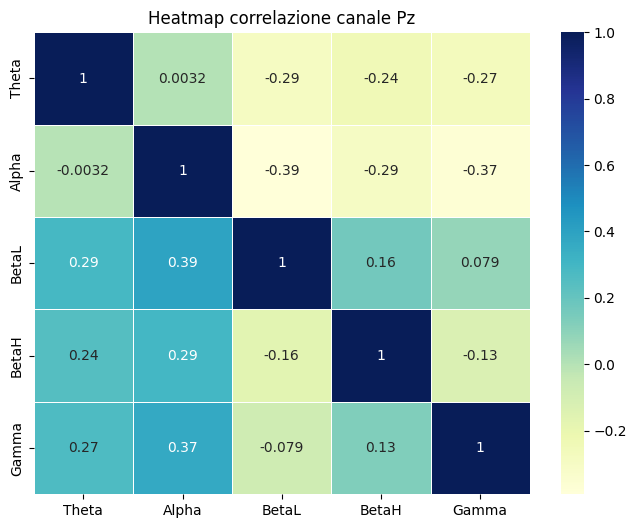

In [49]:
plt.figure(figsize=(8, 6))

sns.heatmap(corr_array, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il titolo
plt.title('Heatmap correlazione canale '+str(c))

# Mostra il plot
plt.show()

In [50]:
# SARA: Rifaccio per tutti gli altri canali

corr_array1 = []
#for c in selectedChannels:
c = 'AF3'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = readings2[c][w]/np.asarray(readings2[c][ww])
      res = stats.spearmanr(yFOC_corr,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array1.append(row)

corr_array2 = []
#for c in selectedChannels:
c = 'AF4'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = readings2[c][w]/np.asarray(readings2[c][ww])
      res = stats.spearmanr(yFOC_corr,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array2.append(row)

corr_array3 = []
#for c in selectedChannels:
c = 'T8'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = readings2[c][w]/np.asarray(readings2[c][ww])
      res = stats.spearmanr(yFOC_corr,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array3.append(row)

corr_array4 = []
#for c in selectedChannels:
c = 'T7'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = readings2[c][w]/np.asarray(readings2[c][ww])
      res = stats.spearmanr(yFOC_corr,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array4.append(row)

<Axes: title={'center': 'T7'}>

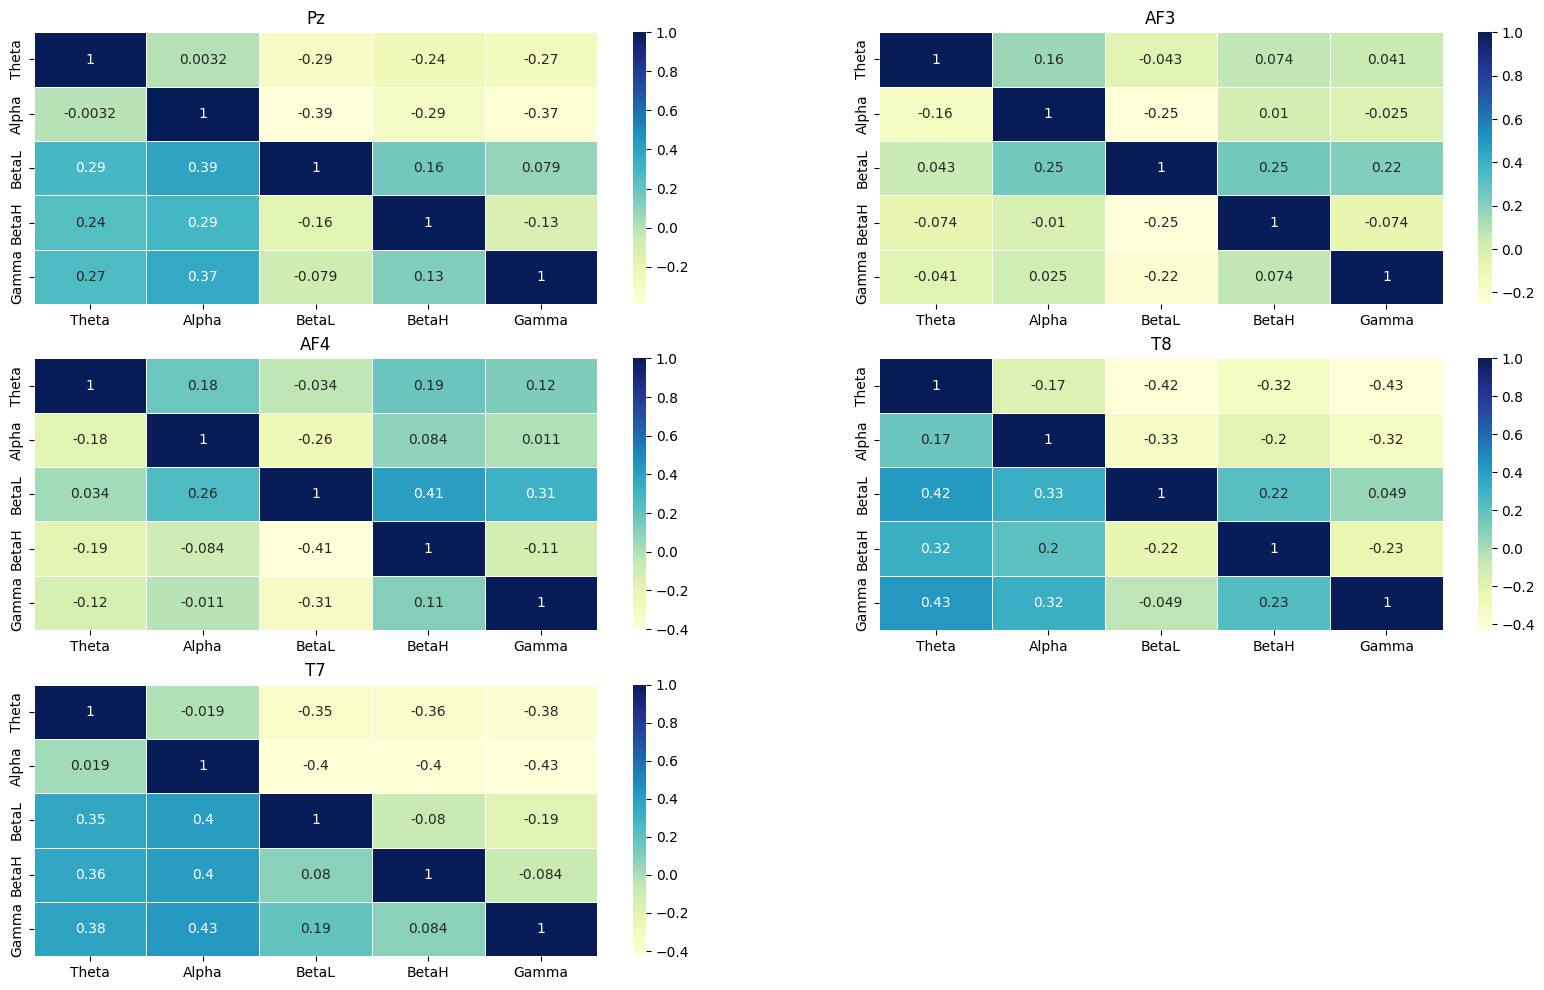

In [51]:
# Crea una figura con subplot
plt.figure(figsize=(20, 12))

# Aggiungi il primo subplot
plt.subplot(3, 2, 1)
plt.title('Pz')
sns.heatmap(corr_array, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 2)
plt.title('AF3')
sns.heatmap(corr_array1, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 3)
plt.title('AF4')
sns.heatmap(corr_array2, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 4)
plt.title('T8')
sns.heatmap(corr_array3, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 5)
plt.title('T7')
sns.heatmap(corr_array4, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

---
# ***3. OUR VERSION OF DAVIDE'S METHOD: CORRECTED READAPTING MISMATCH BETWEEN POW AND DATA***
---

In [52]:
# SARA: salviamo gli indici in cui il valore di tempo cambia, così da usarli come estremi
#       delle finestre di allungamento di MET
currTime = ''
timeIndex = []
timeList = []
for index, item in enumerate(result_dict[i0]['Readings'].values()):
    if(item['Time'])!=currTime:
      timeIndex.append(index)
      timeList.append(item['Time'])
      currTime = item['Time']

# SARA: come atteso, la dimensione voluta per MET e POW è la seguente:
print("Lunghezza voluta:", len(result_dict[i0]['Readings']))

Lunghezza voluta: 773


In [53]:
# SARA: seguendo l'idea di DAVIDE, ripeto il valore di FOCUS per tante volte quante volte si ripete
#       il dato istante di tempo in POW
yFOC_sist = []
yFOC3 = np.array(METreadings['Focus'][METphaseIndex[0]:METphaseIndex[5]+1])
curr = 0
i = 1
while i < (len(timeIndex)):
  rapp = timeIndex[i]-timeIndex[i-1]
  for j in range(rapp):
    yFOC_sist.append(yFOC3[i])
  i=i+1
while len(yFOC_sist) < len(result_dict[i0]['Readings']):
  yFOC_sist.append(yFOC3[len(yFOC3)-1])

---
# ***3. ALL POSSIBLE CORRELATIONS***
---

In [54]:
# SARA: Proviamo a ripetere tutta la procedura da capo per svolgere l'interpolazione
#       Innanzitutto, per rimanere il più fedele possibile al metodo di prima, devo creare "readings"
readings3 = {
'AF3': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'AF4': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'T7':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'T8':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'Pz':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
}
}

In [55]:
# SARA: in questo readings appena inizializzato, inserisco i valori per ogni canale e per ogni onda
for index, item in enumerate(result_dict[i0]['Readings'].values()):
  for c in selectedChannels:
      for w in selectedWaves:
        readings3[c][w].append(item[c][w])

In [56]:
yFOC_sist = np.asarray(yFOC_sist)
yFOC_sist = yFOC_sist.reshape(len(yFOC_sist), 1)

In [57]:
# SARA: ho creato l'ennesima lista (mossa quasi sicuramente non necessaria), ma
#       è comoda perché così calcolo al volo tutte le correlazioni e le salvo
corr_array = []
#for c in selectedChannels:
c = 'Pz'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings3[c][w], dtype=float)/np.asarray(readings3[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array.append(row)

print(corr_array)

[[1, 0.0782, -0.1322, -0.1657, -0.142], [-0.0782, 1, -0.2864, -0.3026, -0.2941], [0.1322, 0.2864, 1, 0.0619, 0.0429], [0.1657, 0.3026, -0.0619, 1, -0.0368], [0.142, 0.2941, -0.0429, 0.0368, 1]]


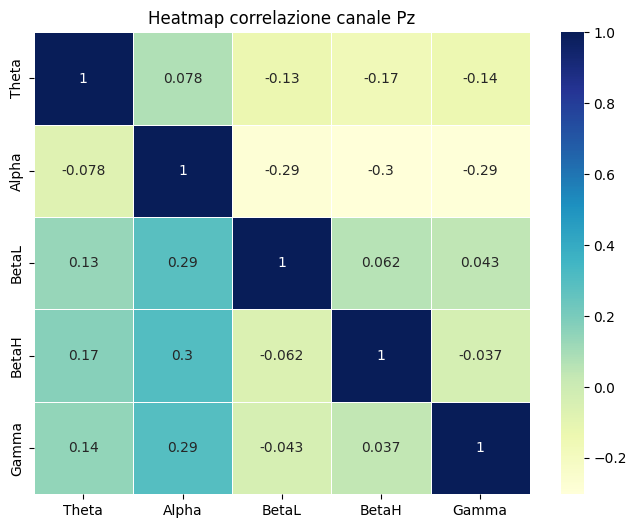

In [58]:
plt.figure(figsize=(8, 6))

sns.heatmap(corr_array, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il titolo
plt.title('Heatmap correlazione canale '+str(c))

# Mostra il plot
plt.show()

In [59]:
# SARA: Rifaccio per tutti gli altri canali

corr_array1 = []
#for c in selectedChannels:
c = 'AF3'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings3[c][w], dtype=float)/np.asarray(readings3[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array1.append(row)

corr_array2 = []
#for c in selectedChannels:
c = 'AF4'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings3[c][w], dtype=float)/np.asarray(readings3[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array2.append(row)

corr_array3 = []
#for c in selectedChannels:
c = 'T8'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings3[c][w], dtype=float)/np.asarray(readings3[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array3.append(row)

corr_array4 = []
#for c in selectedChannels:
c = 'T7'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings3[c][w], dtype=float)/np.asarray(readings3[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array4.append(row)

<Axes: title={'center': 'T7'}>

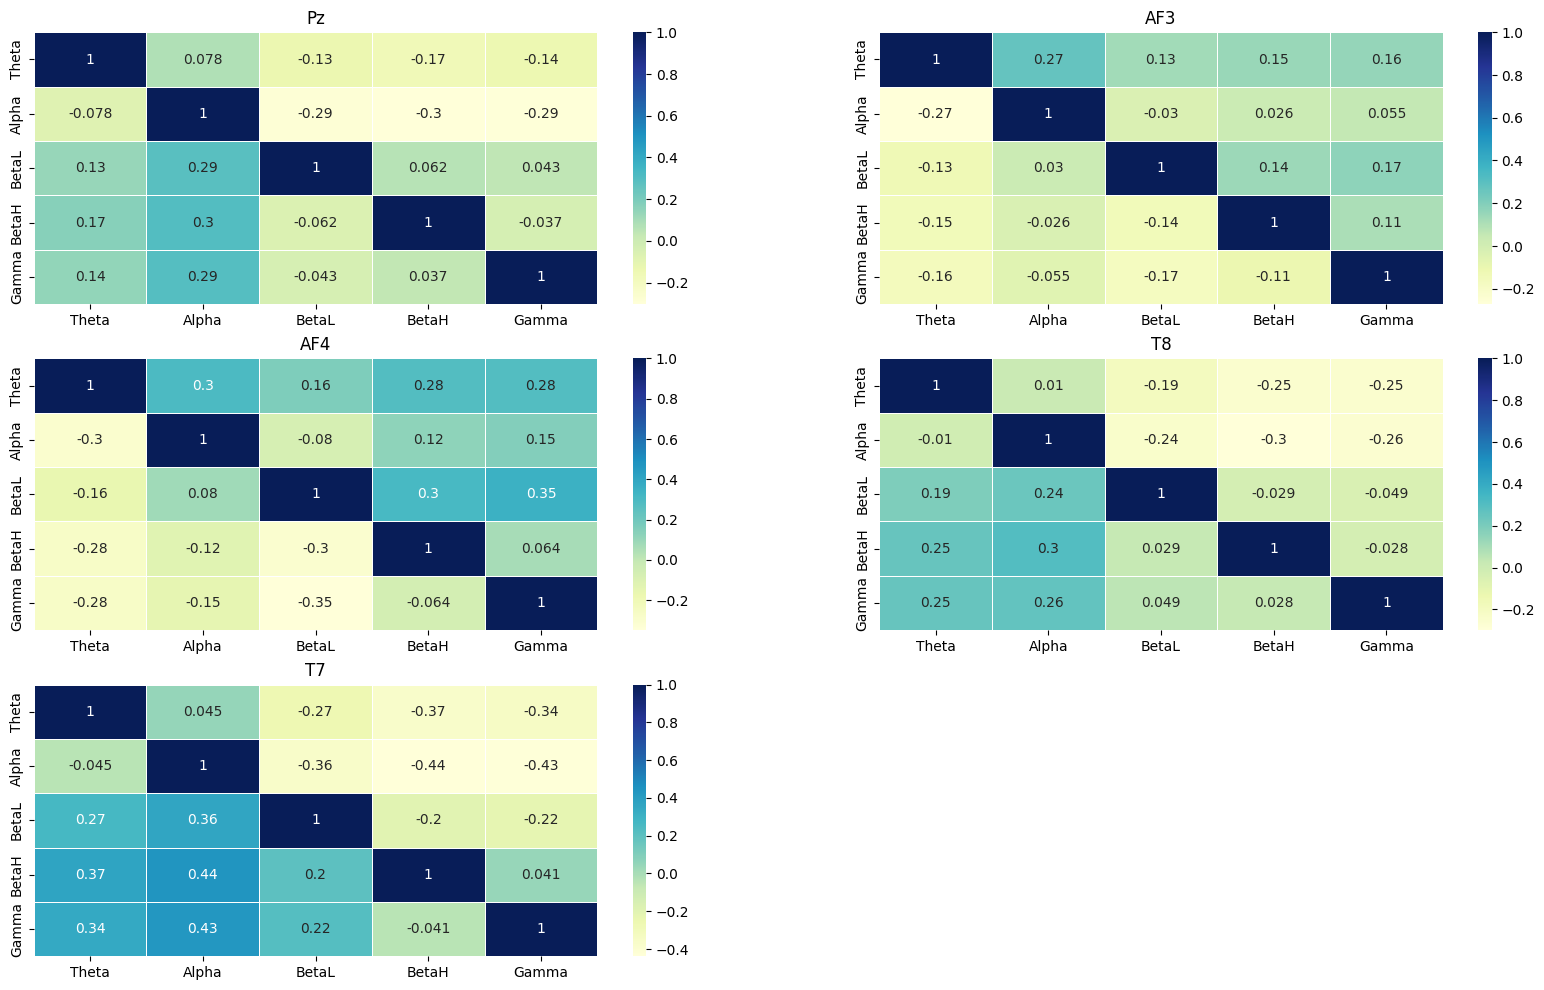

In [60]:
# Crea una figura con subplot
plt.figure(figsize=(20, 12))

# Aggiungi il primo subplot
plt.subplot(3, 2, 1)
plt.title('Pz')
sns.heatmap(corr_array, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 2)
plt.title('AF3')
sns.heatmap(corr_array1, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 3)
plt.title('AF4')
sns.heatmap(corr_array2, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 4)
plt.title('T8')
sns.heatmap(corr_array3, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 5)
plt.title('T7')
sns.heatmap(corr_array4, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

---
# ***4a. NORMALIZATION (only readings) + ALL CORRELATIONS***
---

In [61]:
# SARA ennesimo nuovo dictionary per normalizzare
# SARA: Proviamo a ripetere tutta la procedura da capo per svolgere l'interpolazione
#       Innanzitutto, per rimanere il più fedele possibile al metodo di prima, devo creare "readings"
readings4 = {
'AF3': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'AF4': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'T7':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'T8':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'Pz':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
}
}

In [62]:
# SARA: in questo readings appena inizializzato, inserisco i valori per ogni canale e per ogni onda
for index, item in enumerate(result_dict[i0]['Readings'].values()):
  for c in selectedChannels:
      for w in selectedWaves:
        readings4[c][w].append(item[c][w])

In [63]:
# SARA: ennesima lista che contiene DAVVERO i valori normalizzati

readings5 = {
'AF3': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'AF4': {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'T7':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'T8':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
},
'Pz':  {
  'Theta': [],
  'Alpha': [],
  'BetaL': [],
  'BetaH': [],
  'Gamma': [],
}
}

In [64]:
# SARA: Nuova lista normalizzata
# per ogni canale...
for c in selectedChannels:
  print("---> Step: ", i)
  print("Canale:", c)
  # SARA: ...creo una riga
  row = []
  # SARA: per ogni onda
  for w in selectedWaves:
    print("Onda:", w)
    # SARA: in quella riga, per ogni colonna, metto un valore di onda
    min_valore = np.min(np.array(readings4[c][w], dtype='float'))
    max_valore = np.max(np.array(readings4[c][w], dtype='float'))
    # Applica la normalizzazione Min-Max
    valori_normalizzati = ((np.array(readings4[c][w], dtype='float')) - min_valore) / (max_valore - min_valore)
    readings5[c][w] = valori_normalizzati
  # SARA: dopo aver aggiunto tutti i valori di onda per canale (= riga), aggiungo la riga alla lista di mio interesse

---> Step:  97
Canale: AF3
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma
---> Step:  97
Canale: AF4
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma
---> Step:  97
Canale: T7
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma
---> Step:  97
Canale: T8
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma
---> Step:  97
Canale: Pz
Onda: Theta
Onda: Alpha
Onda: BetaL
Onda: BetaH
Onda: Gamma


In [65]:
# SARA: ho creato l'ennesima lista (mossa quasi sicuramente non necessaria), ma
#       è comoda perché così calcolo al volo tutte le correlazioni e le salvo
corr_array = []
#for c in selectedChannels:
c = 'Pz'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array.append(row)

print(corr_array)

[[1, nan, -0.1414, -0.2065, -0.167], [nan, 1, -0.2689, -0.3259, -0.3025], [0.1414, 0.2689, 1, -0.0201, -0.0375], [0.2065, 0.3259, 0.0201, 1, -0.0262], [0.167, 0.3025, 0.0375, 0.0262, 1]]


<ipython-input-65-4761ab0bcac5>:13: RuntimeWarning: invalid value encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
<ipython-input-65-4761ab0bcac5>:13: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)


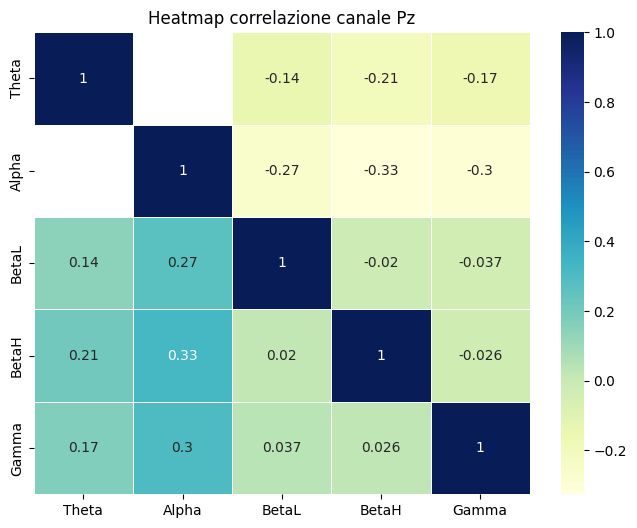

In [66]:
plt.figure(figsize=(8, 6))

sns.heatmap(corr_array, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il titolo
plt.title('Heatmap correlazione canale '+str(c))

# Mostra il plot
plt.show()

In [67]:
# SARA: Rifaccio per tutti gli altri canali

corr_array1 = []
#for c in selectedChannels:
c = 'AF3'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array1.append(row)

corr_array2 = []
#for c in selectedChannels:
c = 'AF4'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array2.append(row)

corr_array3 = []
#for c in selectedChannels:
c = 'T8'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array3.append(row)

corr_array4 = []
#for c in selectedChannels:
c = 'T7'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(yFOC_sist,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array4.append(row)

<ipython-input-67-5276668b9279>:13: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
<ipython-input-67-5276668b9279>:29: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
<ipython-input-67-5276668b9279>:45: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
<ipython-input-67-5276668b9279>:61: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)


<Axes: title={'center': 'T7'}>

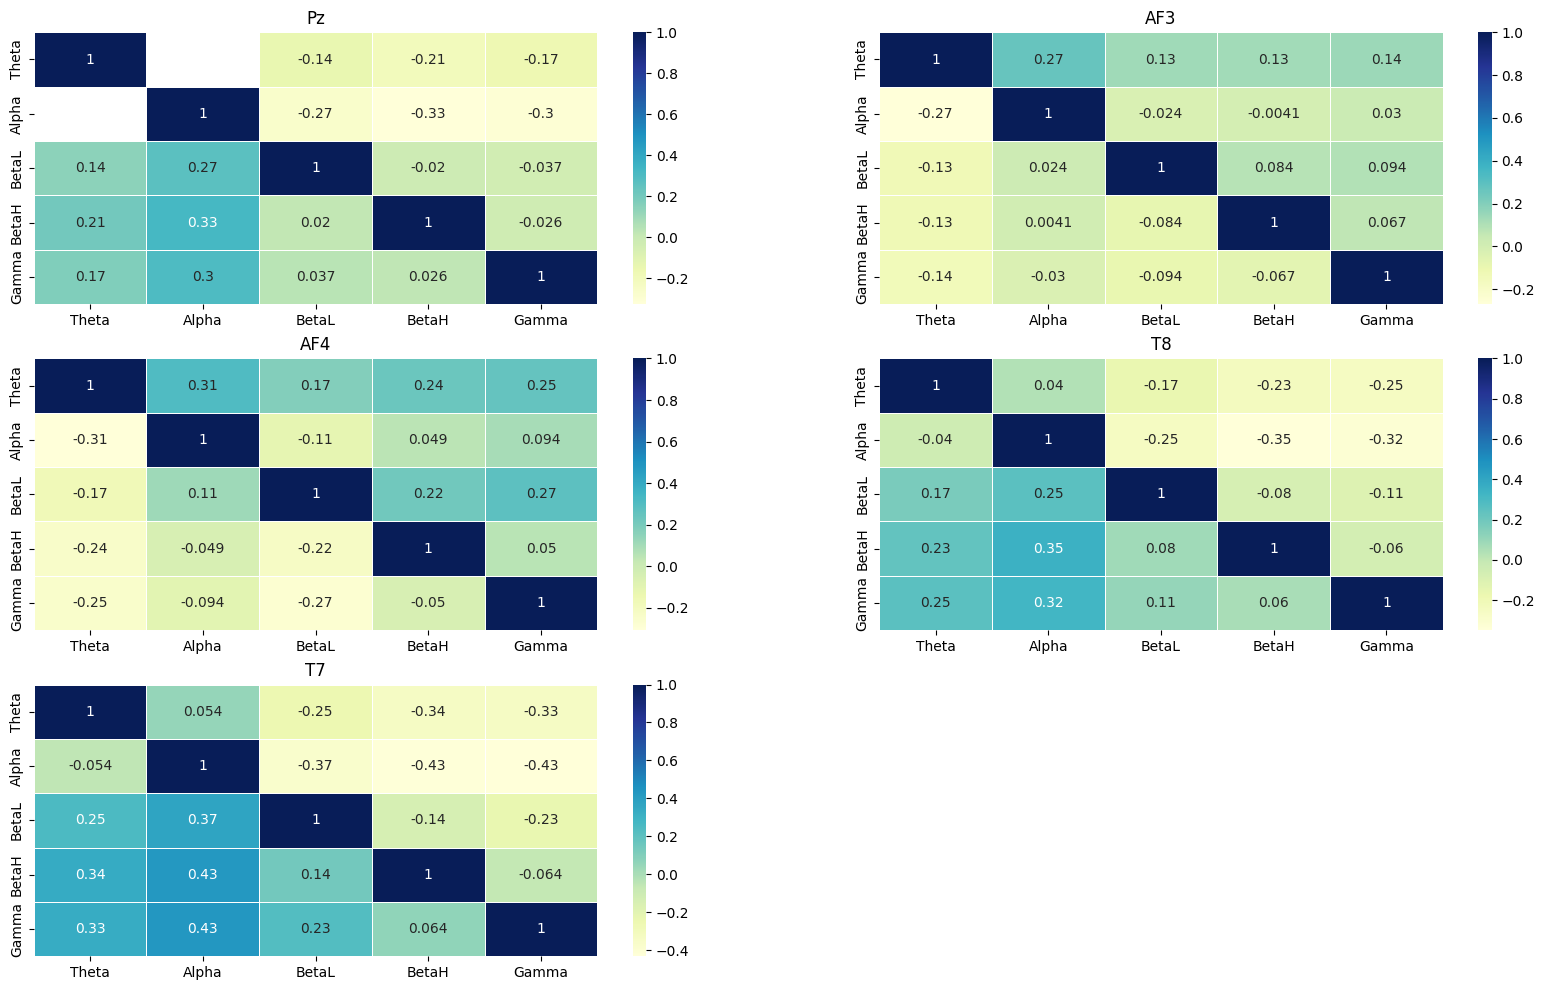

In [68]:
# Crea una figura con subplot
plt.figure(figsize=(20, 12))

# Aggiungi il primo subplot
plt.subplot(3, 2, 1)
plt.title('Pz')
sns.heatmap(corr_array, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 2)
plt.title('AF3')
sns.heatmap(corr_array1, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 3)
plt.title('AF4')
sns.heatmap(corr_array2, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 4)
plt.title('T8')
sns.heatmap(corr_array3, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 5)
plt.title('T7')
sns.heatmap(corr_array4, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

---
# ***4b. NORMALIZATION (readings&focus) + ALL CORRELATIONS***
---

In [69]:
# SARA: normalizziamo anche il focus dai
max_valore2 = np.max(yFOC_sist)
min_valore2 = np.min(yFOC_sist)
valori_normalizzati2 = (yFOC_sist - min_valore2) / (max_valore2 - min_valore2)

In [70]:
# SARA: ho creato l'ennesima lista (mossa quasi sicuramente non necessaria), ma
#       è comoda perché così calcolo al volo tutte le correlazioni e le salvo
corr_array = []
#for c in selectedChannels:
c = 'Pz'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(valori_normalizzati2,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array.append(row)

print(corr_array)

[[1, nan, -0.1414, -0.2065, -0.167], [nan, 1, -0.2689, -0.3259, -0.3025], [0.1414, 0.2689, 1, -0.0201, -0.0375], [0.2065, 0.3259, 0.0201, 1, -0.0262], [0.167, 0.3025, 0.0375, 0.0262, 1]]


<ipython-input-70-1a7a871bd9d2>:13: RuntimeWarning: invalid value encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
<ipython-input-70-1a7a871bd9d2>:13: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)


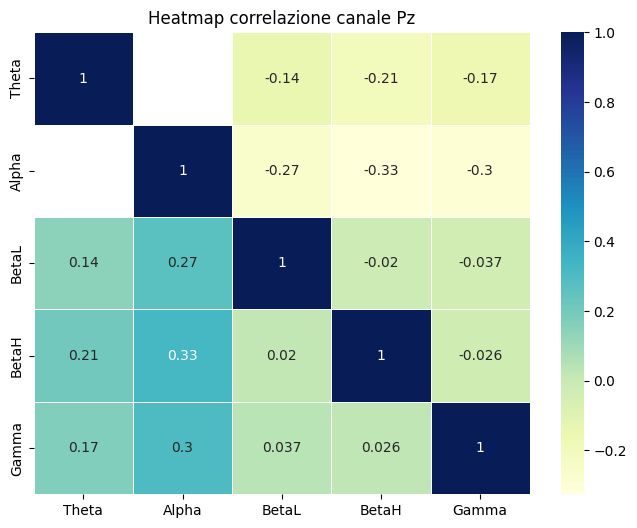

In [71]:
plt.figure(figsize=(8, 6))

sns.heatmap(corr_array, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il titolo
plt.title('Heatmap correlazione canale '+str(c))

# Mostra il plot
plt.show()

In [72]:
# SARA: Rifaccio per tutti gli altri canali

corr_array1 = []
#for c in selectedChannels:
c = 'AF3'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(valori_normalizzati2,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array1.append(row)

corr_array2 = []
#for c in selectedChannels:
c = 'AF4'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(valori_normalizzati2,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array2.append(row)

corr_array3 = []
#for c in selectedChannels:
c = 'T8'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(valori_normalizzati2,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array3.append(row)

corr_array4 = []
#for c in selectedChannels:
c = 'T7'
for w in selectedWaves:
  row = []
  for ww in selectedWaves:
    if w ==  ww:
      corr = 1
      row.append(corr)
    else:
      y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
      res = stats.spearmanr(valori_normalizzati2,y)
      corr = np.round(res.statistic,4)
      row.append(corr)
  corr_array4.append(row)

<ipython-input-72-07ec9764cbd5>:13: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
<ipython-input-72-07ec9764cbd5>:29: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
<ipython-input-72-07ec9764cbd5>:45: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)
<ipython-input-72-07ec9764cbd5>:61: RuntimeWarning: divide by zero encountered in divide
  y = np.asarray(readings5[c][w], dtype=float)/np.asarray(readings5[c][ww], dtype=float)


<Axes: title={'center': 'T7'}>

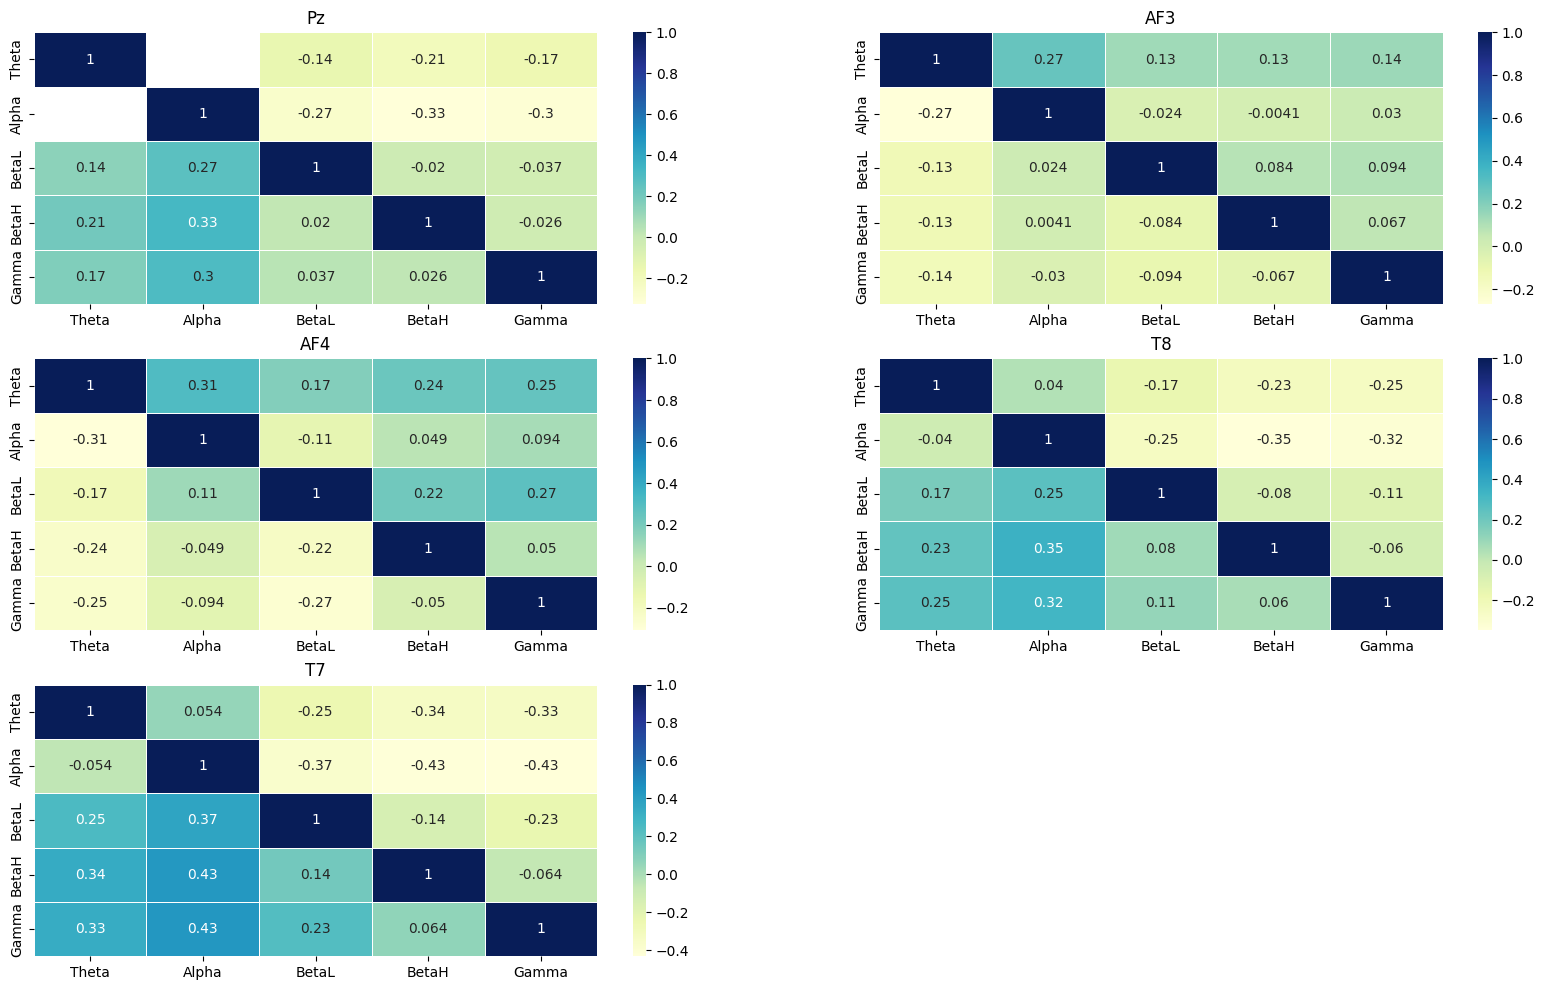

In [73]:
# Crea una figura con subplot
plt.figure(figsize=(20, 12))

# Aggiungi il primo subplot
plt.subplot(3, 2, 1)
plt.title('Pz')
sns.heatmap(corr_array, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 2)
plt.title('AF3')
sns.heatmap(corr_array1, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 3)
plt.title('AF4')
sns.heatmap(corr_array2, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 4)
plt.title('T8')
sns.heatmap(corr_array3, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

# Aggiungi il primo subplot
plt.subplot(3, 2, 5)
plt.title('T7')
sns.heatmap(corr_array4, annot=True, cmap='YlGnBu', linewidths=.5, xticklabels=selectedWaves, yticklabels=selectedWaves)

---
# ***5. R-FACTOR***
#####R = (P_alpha - P_beta) / (P_alpha + P_beta)#####
---

In [74]:
# SARA: Rifaccio per tutti gli altri canali

corr_R = []
#for c in selectedChannels:
for c in selectedChannels:
  y = np.asarray((readings5[c]['Alpha']-((readings5[c]['BetaH']+readings5[c]['BetaL'])/2)), dtype=float)/np.asarray((readings5[c]['Alpha']+((readings5[c]['BetaH']+readings5[c]['BetaL'])/2)), dtype=float)
  res = stats.spearmanr(y, valori_normalizzati)
  corr = np.round(res.statistic,4)
  corr_R.append(corr)

print("Correlazioni tra valori di Focus e fattori R:", corr_R)

Correlazioni tra valori di Focus e fattori R: [0.0023, 0.1492, -0.2759, -0.1454, -0.2051]


---
# ***6. REGRESSION***
---

In [81]:
lst5 = []
# SARA: per ogni canale...
for c in selectedChannels:
  # SARA: ...creo una riga
  row5 = []
  # SARA: per ogni onda
  for w in selectedWaves:
    # SARA: in quella riga, per ogni colonna, metto un valore di onda
    row5.append(readings5[c][w])
  # SARA: dopo aver aggiunto tutti i valori di onda per canale (= riga), aggiungo la riga alla lista di mio interesse
  lst5.append(row5)

  # SARA: conversione della lista in un array
lst5 = np.asarray(lst5)

print(lst5.shape)

(5, 5, 773)


In [77]:
lst5 = np.reshape(lst5, (25, len(lst5[0][0])))
print("Nuova shape della mia lista:", lst5.shape)

Nuova shape della mia lista: (25, 773)


In [78]:
xdata = np.transpose(lst5)
print("Nuova shape della mia lista transposta:", xdata.shape)

Nuova shape della mia lista transposta: (773, 25)


In [82]:
# SARA: vuole in come y una shape (773,)
valori_normalizzati3 = valori_normalizzati2.flatten()
valori_normalizzati3.shape

(773,)

In [83]:
# Generiamo un dataset di esempio
np.random.seed(0)

# Creiamo un modello FNN per la regressione
model = keras.Sequential()
model.add(layers.Input(shape=(25, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='linear'))  # Layer di output con attivazione lineare

# Compilazione
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Addestramento del modello
model.fit(xdata, valori_normalizzati2, epochs=100, batch_size=8)

Epoch 1/100
97/97 [==============================] - 1s 2ms/step - loss: 0.0893 - mean_absolute_error: 0.2349
Epoch 2/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0464 - mean_absolute_error: 0.1896
Epoch 3/100
97/97 [==============================] - 0s 3ms/step - loss: 0.0391 - mean_absolute_error: 0.1705
Epoch 4/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0324 - mean_absolute_error: 0.1528
Epoch 5/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0279 - mean_absolute_error: 0.1372
Epoch 6/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0225 - mean_absolute_error: 0.1197
Epoch 7/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0237 - mean_absolute_error: 0.1176
Epoch 8/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0215 - mean_absolute_error: 0.1139
Epoch 9/100
97/97 [==============================] - 0s 2ms/step - loss: 0.0191 - mean_absolute_error: 0.1078
Epoch 10/1